In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = keras.utils.get_file("venice.jpg", "https://i.imgur.com/oAXHW4J.jpeg")
style_reference_image_path = keras.utils.get_file("starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg")
result_prefix = "venice_StarryNight"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

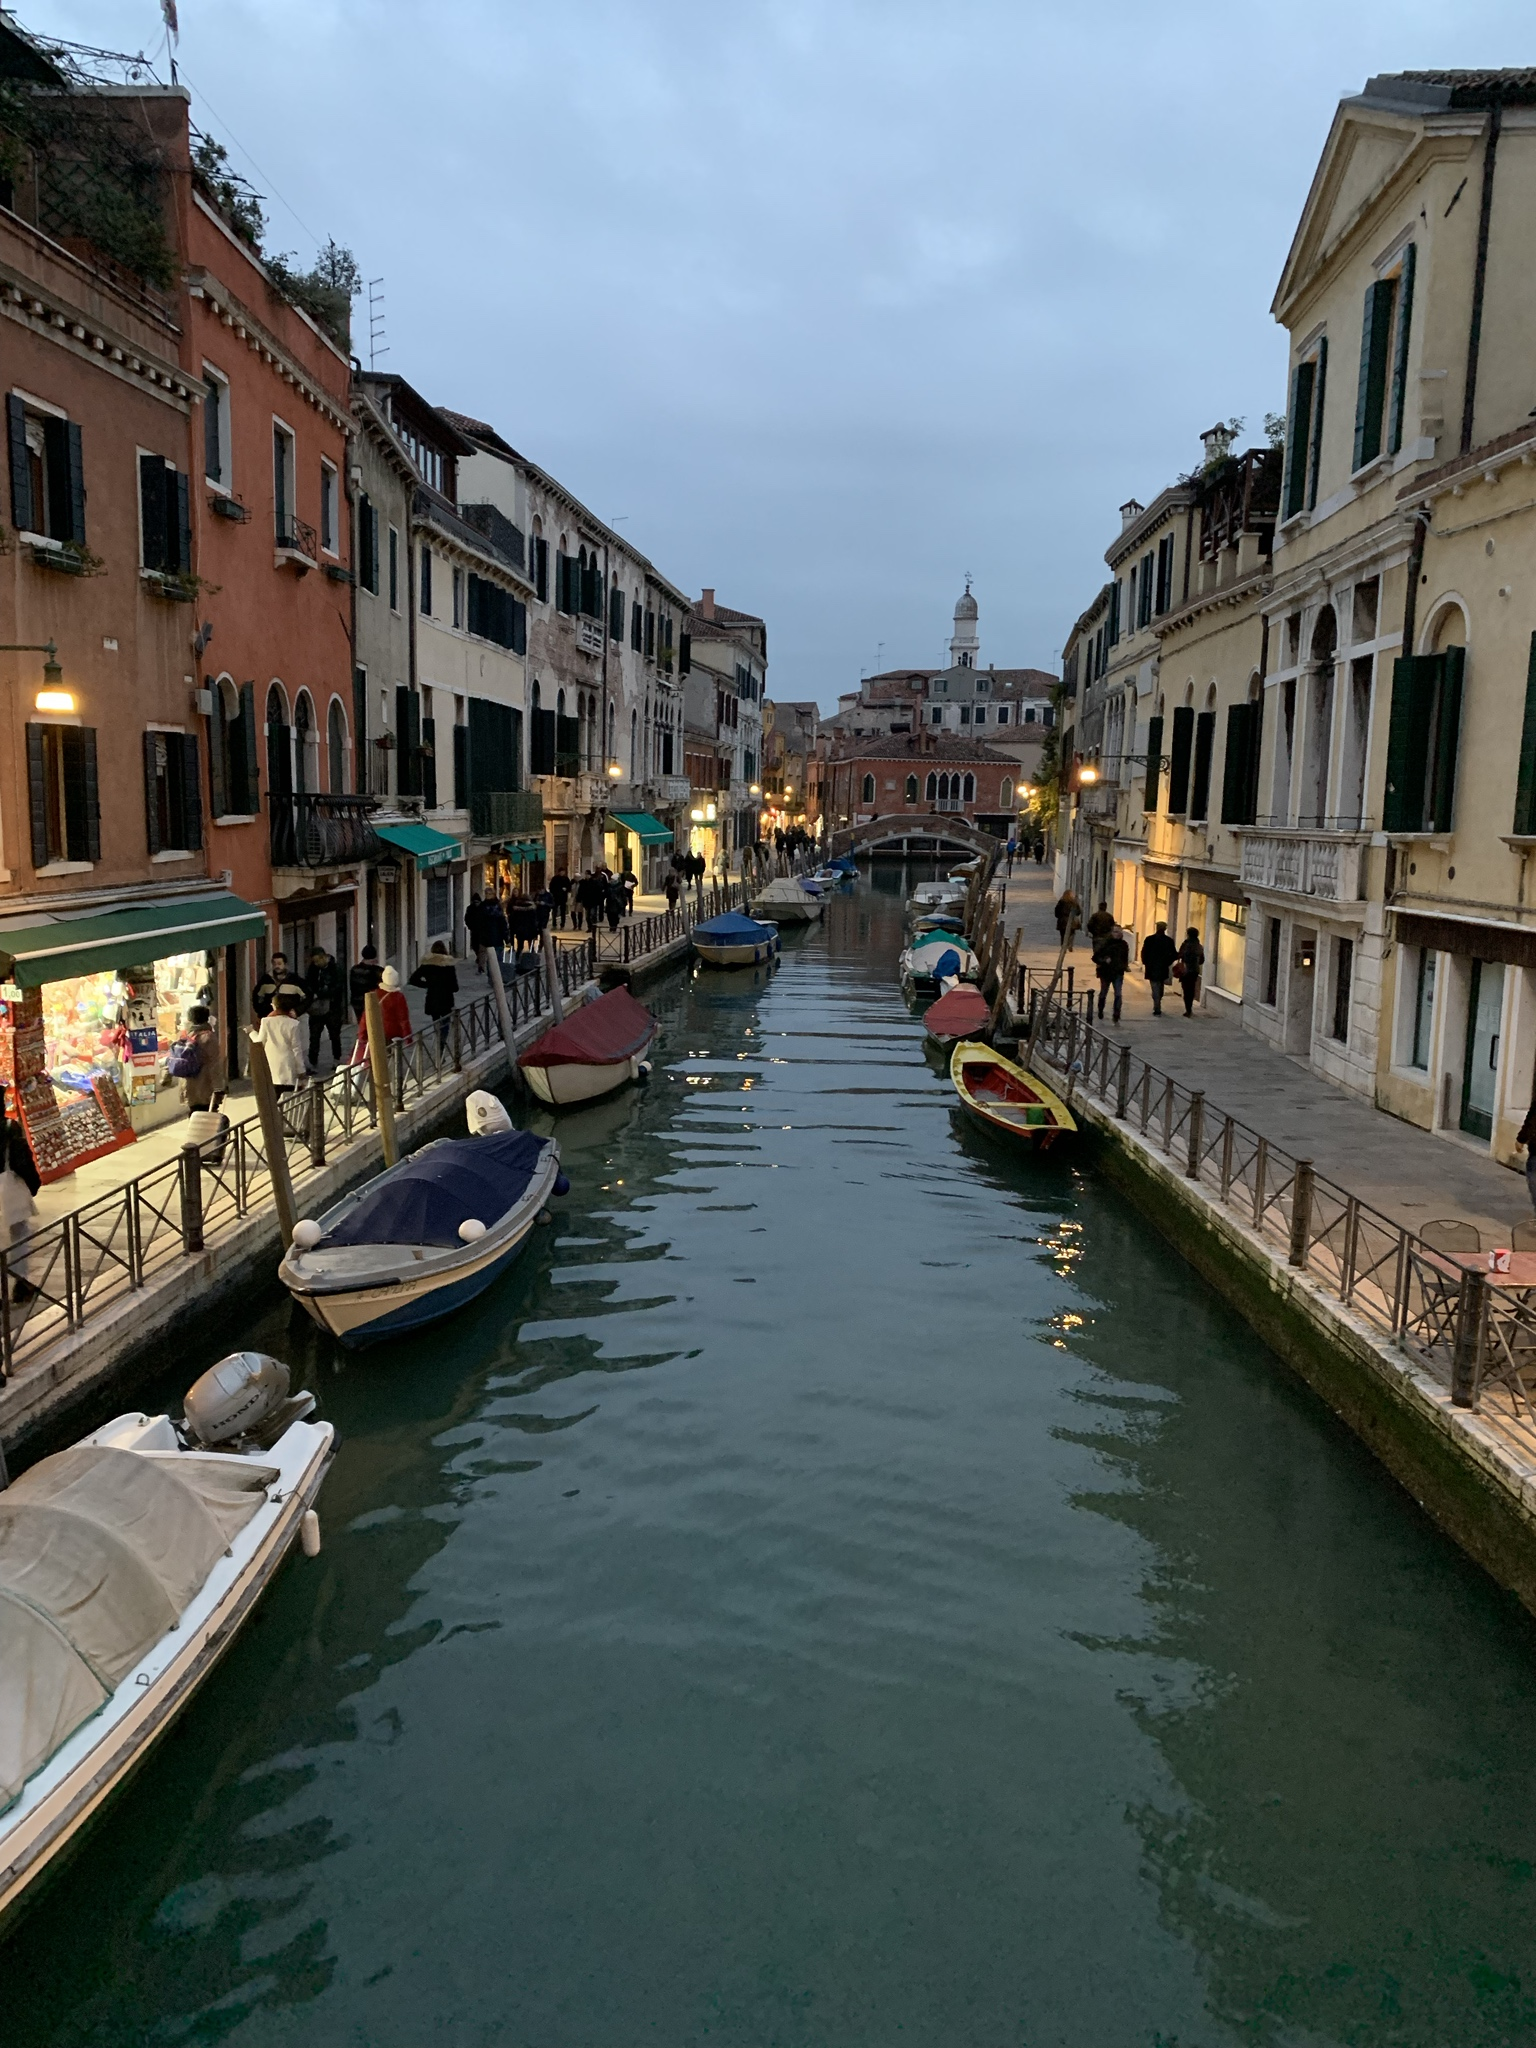

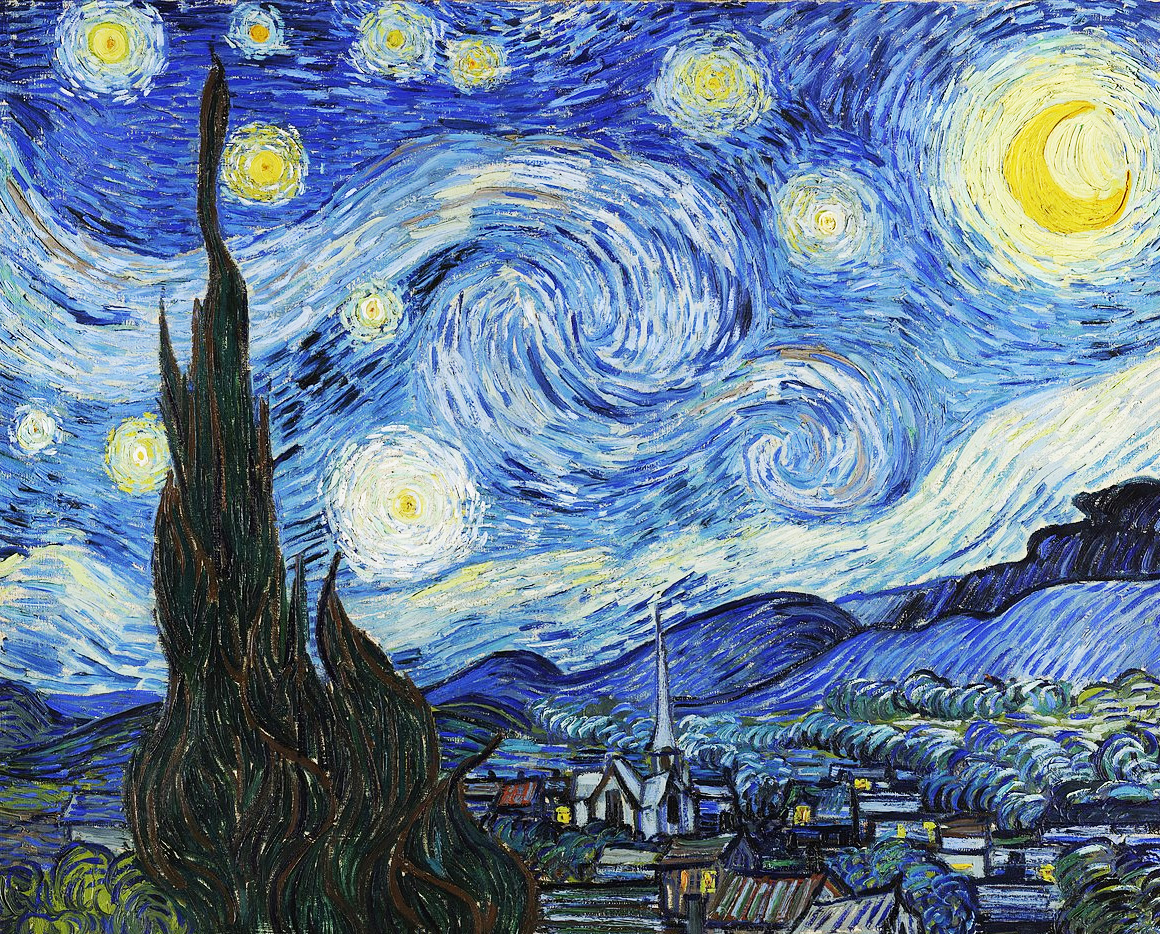

In [12]:
from IPython.display import Image, display
display(Image(base_image_path))
display(Image(style_reference_image_path))

In [14]:
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [15]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))
def total_variation_loss(x):
    a = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :])
    b = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [16]:
model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80142336/80134624 [==============================] - 2s 0us/step


In [18]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [19]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [20]:
optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))
iterations = 500
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])
    print("Iteration %d: loss=%.2f" % (i, loss))
    if i % 500 == 0:
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + ".png"
        keras.preprocessing.image.save_img(fname, img)

Iteration 1: loss=151253.86
Iteration 2: loss=76608.59
Iteration 3: loss=46449.08
Iteration 4: loss=53252.92
Iteration 5: loss=44428.76
Iteration 6: loss=52158.23
Iteration 7: loss=31023.23
Iteration 8: loss=28441.19
Iteration 9: loss=22342.00
Iteration 10: loss=19800.55
Iteration 11: loss=19047.30
Iteration 12: loss=18082.84
Iteration 13: loss=18711.43
Iteration 14: loss=16806.13
Iteration 15: loss=16704.94
Iteration 16: loss=14790.43
Iteration 17: loss=14328.61
Iteration 18: loss=13423.83
Iteration 19: loss=13086.36
Iteration 20: loss=12630.79
Iteration 21: loss=12386.55
Iteration 22: loss=12072.92
Iteration 23: loss=11867.06
Iteration 24: loss=11606.85
Iteration 25: loss=11418.12
Iteration 26: loss=11191.33
Iteration 27: loss=11015.56
Iteration 28: loss=10820.92
Iteration 29: loss=10662.00
Iteration 30: loss=10499.29
Iteration 31: loss=10361.06
Iteration 32: loss=10225.76
Iteration 33: loss=10108.65
Iteration 34: loss=9998.51
Iteration 35: loss=9901.21
Iteration 36: loss=9816.53
Ite

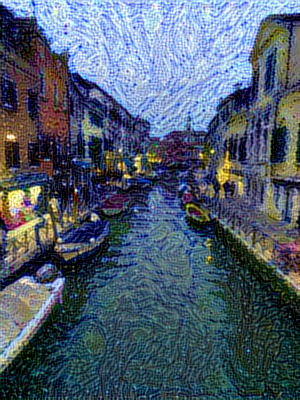

In [21]:
display(Image(result_prefix+".png"))